# Build repetition codes

## Background

To enable real-time quantum error correction (QEC), we require the capability to dynamically control quantum program flow during execution so that quantum gates may be conditioned on measurement results. In this tutorial, we will run the bit-flip code, which is a very simple form of QEC. We will demonstrate a dynamic quantum circuit that can protect an encoded qubit from a single bit-flip error, and then evaluate the performance of the bit-flip code.

We can exploit additional ancilla qubits and entanglement to measure what are known as *stabilizers* that do not transform our encoded quantum information, while still informing us of some classes of errors that may have occurred. A quantum stabilizer code encodes $k$ logical qubits into $n$ physical qubits. Stabilizer codes critically focus on correcting a discrete error set with support from the Pauli group $\Pi^n$. Assume the set of possible errors are $ \epsilon \subset \Pi^n$. For example, in a bit-flip code with three qubits encoding the quantum state, we will have $\epsilon = \{IIX, IXI, XII\}$. We can measure the stabilizers and observing their eigenvalues to dete

## Setup

In [1]:
# Qiskit imports
from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.result import marginal_counts

# Qiskit IBM Provider
from qiskit_ibm_provider import IBMProvider, least_busy

import warnings
warnings.filterwarnings("ignore")

In [2]:
provider = IBMProvider()
backend = least_busy(provider.backends(simulator=False, operational=True))
backend

<IBMBackend('ibm_kyiv')>

## Build a bit-flip stabilizer circuit

The bit-flip code is among the simplest examples of a stabilizer code. It can protect our state against a single bit-flip (X) error on any of the encoding qubits. If we consider the action of bit-flip error $X$ which maps $|0\rangle \rightarrow |1\rangle$ and $|1\rangle \rightarrow |0\rangle$ on any of our qubits, we have $\epsilon = \{E_0, E_1, E_2 \} = \{IIX, IXI, XII\}$. The code requires five qubits: three are used to encode the protected state, and the remaining two are used as stabilizer measurement ancillas.

In [3]:
qreg_data = QuantumRegister(3)
qreg_measure = QuantumRegister(2)
creg_data = ClassicalRegister(3)
creg_syndrome = ClassicalRegister(2)
state_data = qreg_data[0]
ancillas_data = qreg_data[1:]

def build_qc():
    """Build a typical error correction circuit"""
    return QuantumCircuit(qreg_data, qreg_measure, creg_data, creg_syndrome)

def initialize_qubits(circuit: QuantumCircuit):
    """Initialize qubit to |1>"""
    circuit.x(qreg_data[0])
    circuit.barrier(qreg_data)
    return circuit

def encode_bit_flip(circuit, state, ancillas) -> QuantumCircuit:
    """Encode bit-flip. This is done by simply adding a cx"""
    for ancilla in ancillas:
        circuit.cx(state, ancilla)
    circuit.barrier(state, *ancillas)
    return circuit

def measure_syndrome_bit(circuit, qreg_data, qreg_measure, creg_measure):
    """
        Measure the syndrome by measuring the parity.
        We reset our ancilla qubits after measuring the stabilizer
        so we can reuse them for repeated stabilizer measurements.
        Because we have already observed the state of the qubit,
        we can write the conditional reset protocol directly to
        avoid another round of qubit measurement if we used
        the `reset` instruction.
    """
    circuit.cx(qreg_data[0], qreg_measure[0])
    circuit.cx(qreg_data[1], qreg_measure[0])
    circuit.cx(qreg_data[0], qreg_measure[1])
    circuit.cx(qreg_data[2], qreg_measure[1])
    circuit.barrier(*qreg_data, *qreg_measure)
    circuit.measure(qreg_measure, creg_measure)
    with circuit.if_test((creg_syndrome[0], 1)):
        circuit.x(qreg_measure[0])
    with circuit.if_test((creg_syndrome[1], 1)):
        circuit.x(qreg_measure[1])
    circuit.barrier(*qreg_data, *qreg_measure)
    return circuit

def apply_correction_bit(circuit, qreg_data, creg_syndrome):
    """We can detect where an error occurred and correct our state"""
    with circuit.if_test((creg_syndrome, 3)):
        circuit.x(qreg_data[0])
    with circuit.if_test((creg_syndrome, 1)):
        circuit.x(qreg_data[1])
    with circuit.if_test((creg_syndrome, 2)):
        circuit.x(qreg_data[2])
    circuit.barrier(qreg_data)
    return circuit

def apply_final_readout(circuit, qreg_data, creg_data):
    """Read out the final measurements"""
    circuit.barrier(qreg_data)
    circuit.measure(qreg_data, creg_data)
    return circuit

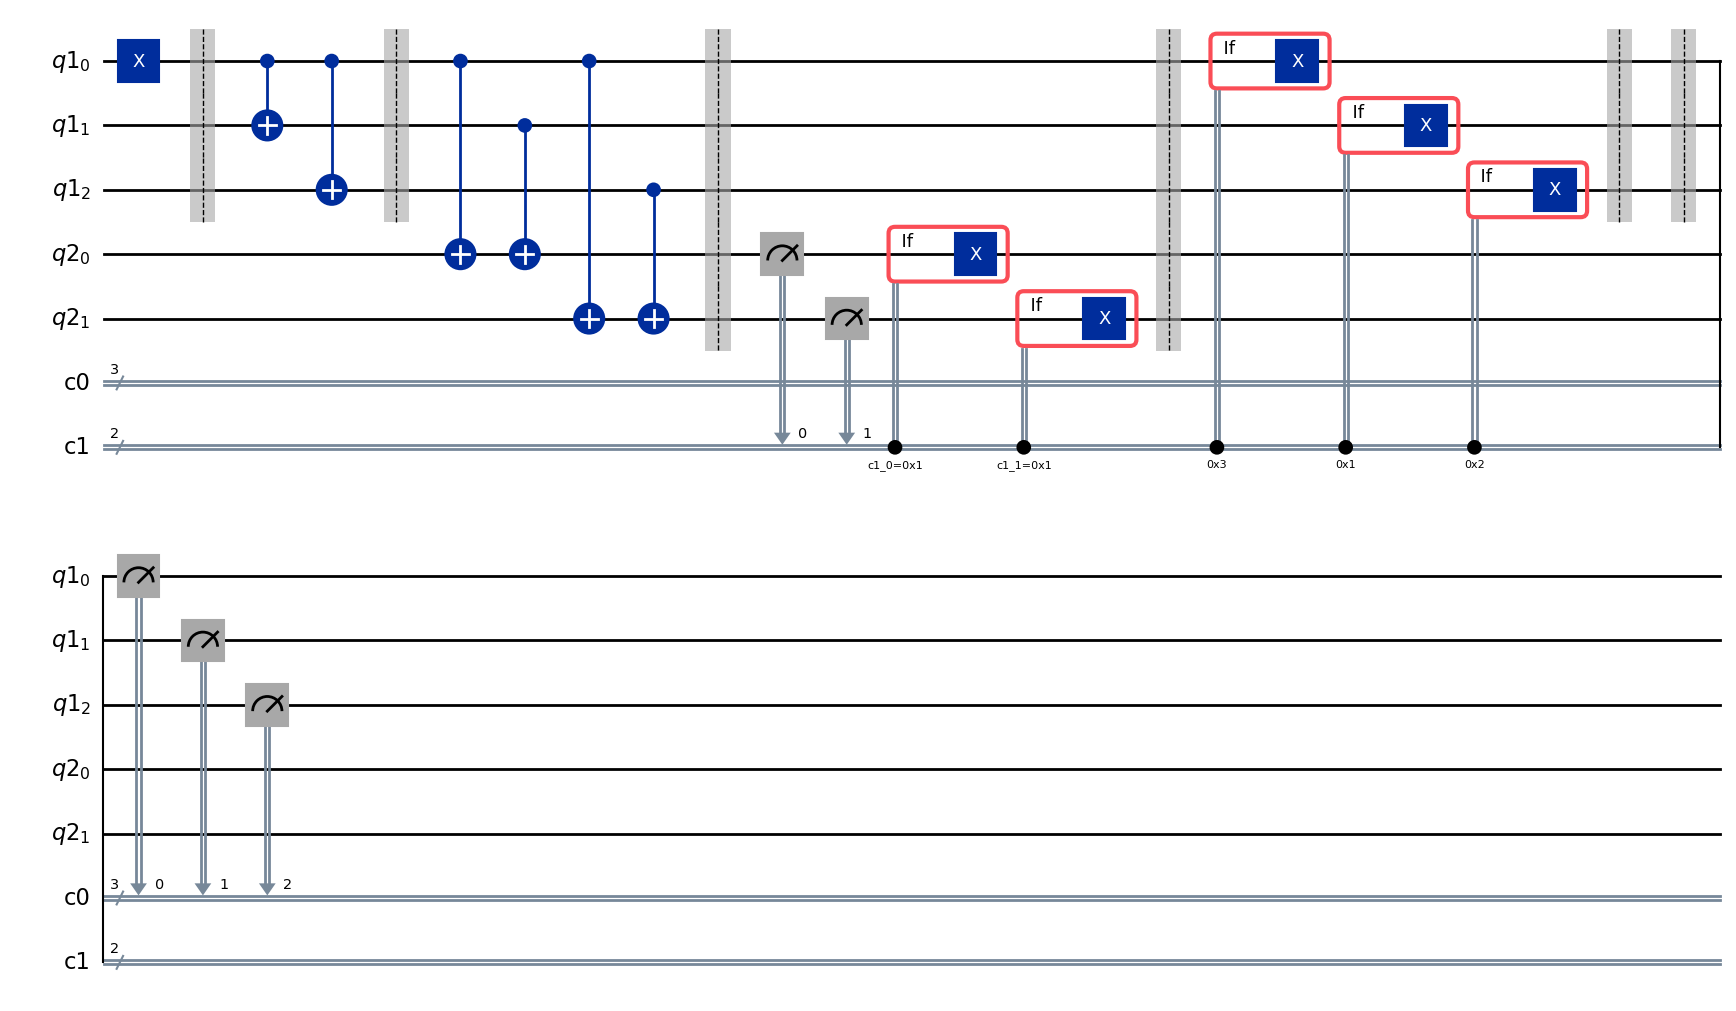

In [4]:
def build_error_correction_sequence(apply_correction: bool) -> QuantumCircuit:

    circuit = build_qc()
    circuit = initialize_qubits(circuit)
    circuit = encode_bit_flip(circuit, state_data, ancillas_data)
    circuit = measure_syndrome_bit(circuit, qreg_data, qreg_measure, creg_syndrome)

    if apply_correction:
        circuit = apply_correction_bit(circuit, qreg_data, creg_syndrome)

    circuit = apply_final_readout(circuit,  qreg_data, creg_data)
    return circuit

circuit = build_error_correction_sequence(apply_correction=True)
circuit.draw(output="mpl", style='iqp')

## Optimize the circuit

We will transpile the circuit to select the best qubit layout and routing.

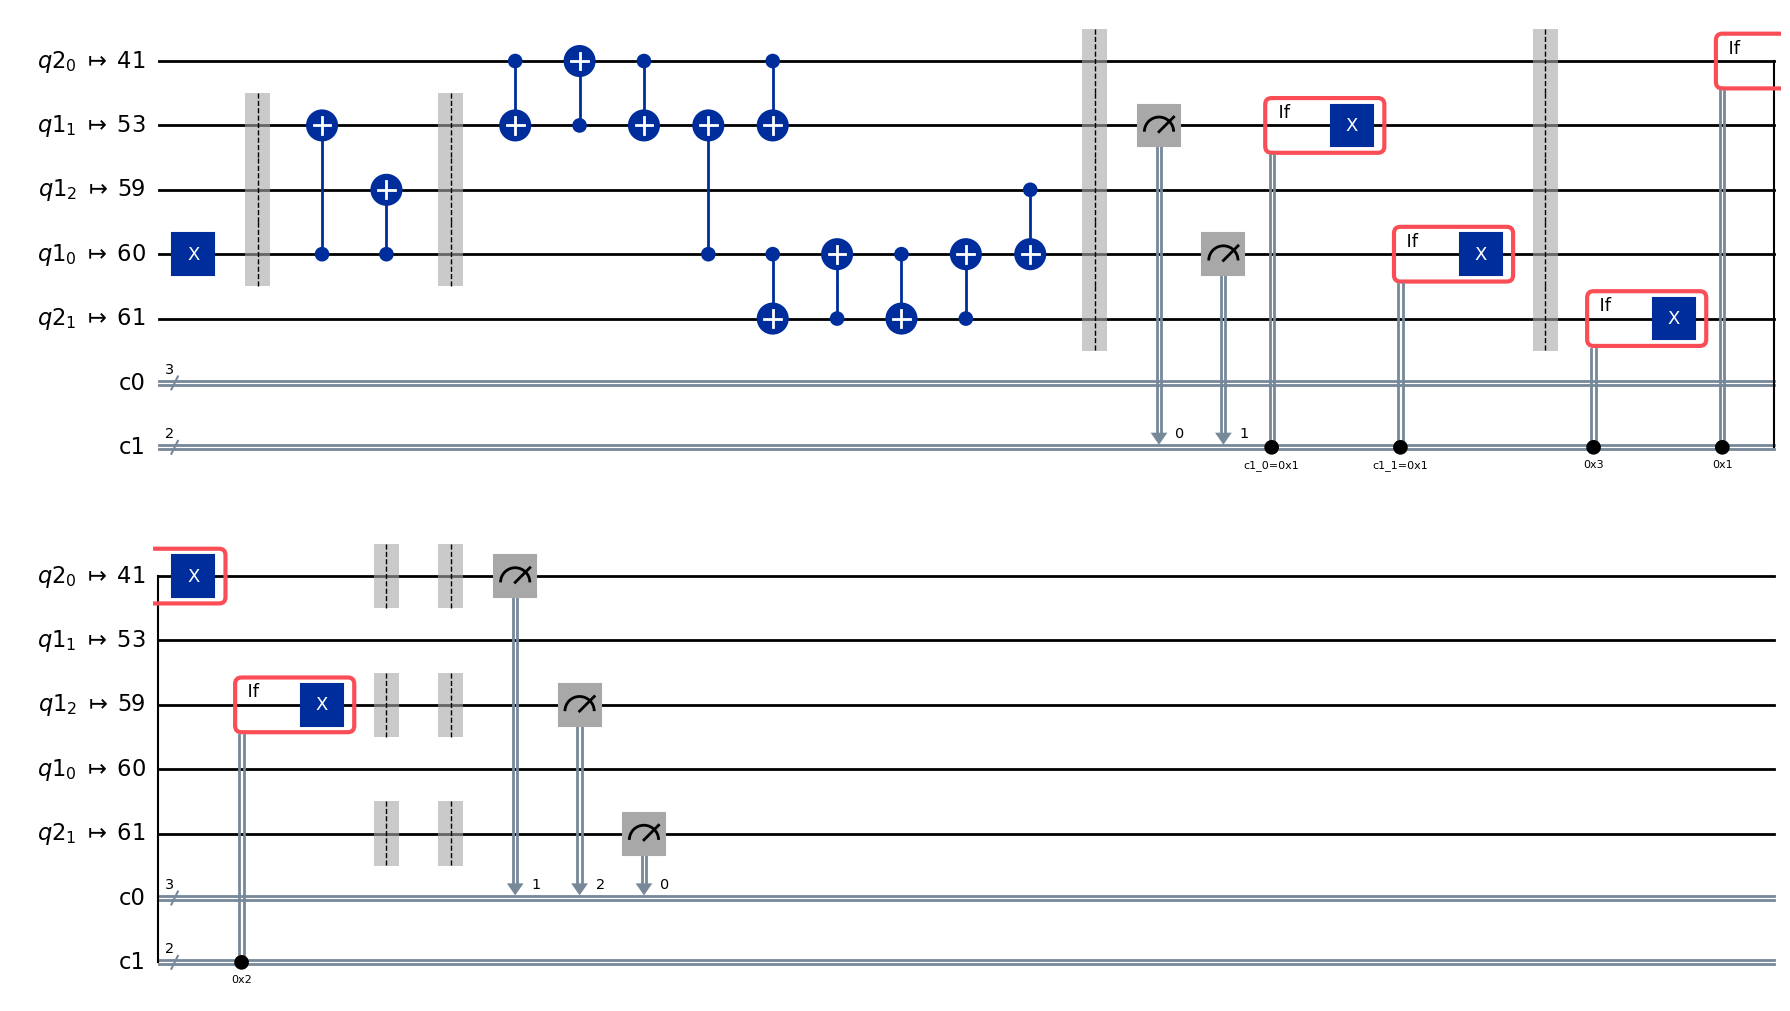

In [5]:
transpiled_circuit = transpile(circuit, backend)
transpiled_circuit.draw(output="mpl", style='iqp', idle_wires=False)

In [6]:
no_correction_circuit = build_error_correction_sequence(apply_correction=False)
transpiled_no_correction_circuit = transpile(no_correction_circuit, backend)

## Execute the circuit in hardware

We'll run the version with correction applied, and one without correction

In [7]:
job_no_correction = backend.run(transpiled_no_correction_circuit, shots=1000, dynamic=True)
result_no_correction = job_no_correction.result()

In [8]:
job_with_correction = backend.run(transpiled_circuit, shots=1000, dynamic=True)
result_with_correction = job_with_correction.result()

## Analyze the results

In [9]:
data_indices = list(range(len(qreg_data)))
syndrome_indices = list(range(data_indices[-1] + 1, len(qreg_data) + len(qreg_measure)))

def decode_result(data_counts, syndrome_counts):
    shots = sum(data_counts.values())
    success_trials = data_counts.get('000', 0) + data_counts.get('111', 0)
    failed_trials = shots - success_trials
    error_correction_events = shots - syndrome_counts.get('00', 0)
    print(f"Bit flip errors were detected/corrected on {error_correction_events}/{shots} trials")
    print(f"A final parity error was detected on {failed_trials}/{shots} trials")

In [10]:
non_corrected_marginalized_data_result = marginal_counts(result_no_correction, data_indices)
non_corrected_marginalized_syndrome_result = marginal_counts(result_no_correction, syndrome_indices)

print(f'Completed bit code experiment data measurement counts {non_corrected_marginalized_data_result.get_counts(0)}')
print(f'Completed bit code experiment syndrome measurement counts {non_corrected_marginalized_syndrome_result.get_counts(0)}')
decode_result(non_corrected_marginalized_data_result.get_counts(0), non_corrected_marginalized_syndrome_result.get_counts(0))

Completed bit code experiment data measurement counts {'000': 5, '001': 7, '011': 100, '100': 3, '110': 31, '111': 818, '010': 2, '101': 34}
Completed bit code experiment syndrome measurement counts {'00': 862, '10': 73, '11': 13, '01': 52}
Bit flip errors were detected/corrected on 138/1000 trials
A final parity error was detected on 177/1000 trials


In [11]:
corrected_marginalized_data_result = marginal_counts(result_with_correction, data_indices)
corrected_marginalized_syndrome_result = marginal_counts(result_with_correction, syndrome_indices)

print(f'Completed bit code experiment data measurement counts {corrected_marginalized_data_result.get_counts(0)}')
print(f'Completed bit code experiment syndrome measurement counts {corrected_marginalized_syndrome_result.get_counts(0)}')
decode_result(corrected_marginalized_data_result.get_counts(0), corrected_marginalized_syndrome_result.get_counts(0))

Completed bit code experiment data measurement counts {'000': 6, '001': 1, '010': 7, '011': 19, '110': 29, '111': 886, '100': 2, '101': 50}
Completed bit code experiment syndrome measurement counts {'00': 902, '10': 37, '11': 8, '01': 53}
Bit flip errors were detected/corrected on 98/1000 trials
A final parity error was detected on 108/1000 trials


In [12]:
import qiskit_ibm_provider

qiskit_ibm_provider.version.get_version_info()

'0.9.0'

In [13]:
import qiskit

qiskit.version.get_version_info()

'1.0.0rc1'